# Forecasting Demo

This notebook demonstrates the three modeling modules in `timeseries_toolkit`:

1. **Kalman Filter** - State-space modeling with `AutoKalmanFilter`
2. **Regime Detection** - HMM-based market regime identification
3. **Global Boosting Forecaster** - LightGBM multi-entity forecasting

All examples use real market data.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import contextlib, io

np.random.seed(42)

print('Setup complete.')

Setup complete.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print('Plotting style configured.')

Plotting style configured.


## 1. Fetch Data

In [3]:
from timeseries_toolkit.data_sources import CryptoDataLoader, EquityDataLoader

crypto = CryptoDataLoader()
btc_df = crypto.get_prices(['BTC-USD'], period='2y')
btc_close = btc_df[[c for c in btc_df.columns if 'Close' in c or 'close' in c][0]]
btc_close.name = 'BTC-USD'

equities = EquityDataLoader()
spy_df = equities.get_prices(['SPY'], period='2y')
spy_close = spy_df[[c for c in spy_df.columns if 'Close' in c or 'close' in c][0]]
spy_close.name = 'SPY'

print(f'BTC-USD: {len(btc_close)} days, last price: ${btc_close.iloc[-1]:,.0f}')
print(f'SPY:     {len(spy_close)} days, last price: ${spy_close.iloc[-1]:,.2f}')

BTC-USD: 732 days, last price: $81,219
SPY:     502 days, last price: $691.97


---
## 2. Kalman Filter

The `AutoKalmanFilter` wraps `statsmodels.UnobservedComponents` and provides:
- Automatic model fitting
- Smoothing (extract the latent trend from noisy observations)
- Multi-step forecasting
- Component extraction (trend, cycle, seasonal)

### 2.1 Fit and Smooth SPY

In [4]:
from timeseries_toolkit.models import AutoKalmanFilter

# Prepare daily series with frequency
spy_daily = spy_close.copy()
spy_daily = spy_daily.asfreq('D', method='ffill')

kf = AutoKalmanFilter(level='local linear trend')
kf.fit(spy_daily)

smoothed = kf.smooth()
print(f'Smoothed series length: {len(smoothed)}')
print(f'Last smoothed value: ${smoothed.iloc[-1]:,.2f}')
print(f'Last actual value:   ${spy_daily.iloc[-1]:,.2f}')
print(f'Smoothing error:     ${abs(smoothed.iloc[-1] - spy_daily.iloc[-1]):,.2f}')

Smoothed series length: 731
Last smoothed value: $692.14
Last actual value:   $691.97
Smoothing error:     $0.17


### 2.2 Forecast SPY

In [5]:
forecast = kf.forecast(steps=7)

print('SPY 7-Day Kalman Forecast:')
for i, (date, val) in enumerate(forecast.items(), 1):
    print(f'  Day {i}: ${val:,.2f}')

print(f'\nForecast direction: {"UP" if forecast.iloc[-1] > spy_daily.iloc[-1] else "DOWN"}')
pct_change = (forecast.iloc[-1] / spy_daily.iloc[-1] - 1) * 100
print(f'Expected 7-day change: {pct_change:+.2f}%')

SPY 7-Day Kalman Forecast:
  Day 1: $692.44
  Day 2: $692.75
  Day 3: $693.05
  Day 4: $693.35
  Day 5: $693.65
  Day 6: $693.95
  Day 7: $694.26

Forecast direction: UP
Expected 7-day change: +0.33%


### 2.3 Extract Components

In [6]:
components = kf.get_components()

print('Kalman filter components:')
for name, comp in components.items():
    if comp is not None and len(comp) > 0:
        print(f'  {name}: length={len(comp)}, last value={comp.iloc[-1]:.4f}')

Kalman filter components:
  level: length=731, last value=692.1413
  trend: length=731, last value=0.3020


### 2.4 Kalman vs ARIMA Comparison

In [7]:
from timeseries_toolkit.models import compare_kalman_vs_arima

# Use last 200 days of SPY, holdout last 7 for testing
spy_sample = spy_daily.dropna().tail(200)

comparison = compare_kalman_vs_arima(spy_sample, holdout=7)

print('Kalman vs ARIMA Benchmark (7-day holdout):')
print(f'  Kalman RMSE: {comparison["kalman_rmse"]:.4f}')
print(f'  ARIMA RMSE:  {comparison["arima_rmse"]:.4f}')
print(f'  Kalman MAE:  {comparison["kalman_mae"]:.4f}')
print(f'  ARIMA MAE:   {comparison["arima_mae"]:.4f}')
print(f'  Winner:      {comparison["winner"]}')
print(f'  ARIMA order: {comparison["arima_order"]}')

Kalman vs ARIMA Benchmark (7-day holdout):
  Kalman RMSE: 2.8050
  ARIMA RMSE:  4.1472
  Kalman MAE:  2.2009
  ARIMA MAE:   3.3571
  Winner:      kalman
  ARIMA order: (0, 1, 0)


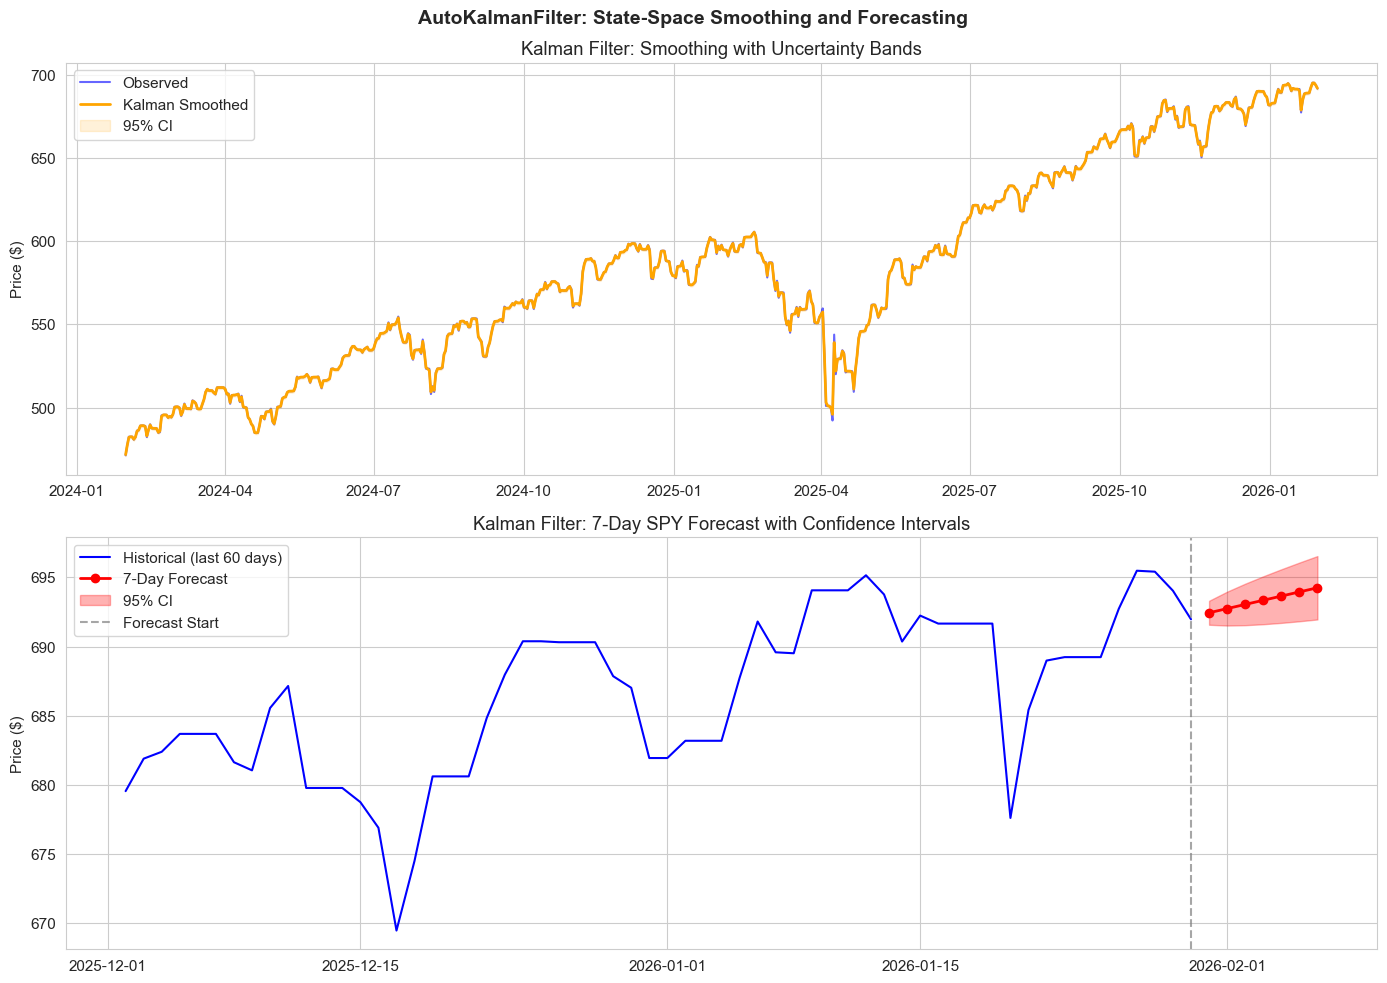

In [8]:
# ── Kalman Filter: Smoothing + Forecast Visualization ──
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top panel: Observed vs Smoothed
axes[0].plot(spy_daily, label='Observed', alpha=0.6, color='blue')
axes[0].plot(smoothed, label='Kalman Smoothed', color='orange', linewidth=2)
# Compute uncertainty band from smoothing residuals
resid = spy_daily.values[:len(smoothed)] - smoothed.values
resid_std = np.nanstd(resid)
axes[0].fill_between(smoothed.index,
                     smoothed - 1.96 * resid_std,
                     smoothed + 1.96 * resid_std,
                     alpha=0.15, color='orange', label='95% CI')
axes[0].set_title('Kalman Filter: Smoothing with Uncertainty Bands')
axes[0].set_ylabel('Price ($)')
axes[0].legend()

# Bottom panel: Historical + Forecast
axes[1].plot(spy_daily.iloc[-60:], label='Historical (last 60 days)', color='blue')
# Forecast with confidence interval
fc_std = resid_std * np.sqrt(np.arange(1, len(forecast) + 1))
fc_index = forecast.index
axes[1].plot(fc_index, forecast.values, label='7-Day Forecast', color='red', linewidth=2, marker='o')
axes[1].fill_between(fc_index,
                     forecast.values - 1.96 * fc_std,
                     forecast.values + 1.96 * fc_std,
                     alpha=0.3, color='red', label='95% CI')
axes[1].axvline(x=spy_daily.index[-1], color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
axes[1].set_title('Kalman Filter: 7-Day SPY Forecast with Confidence Intervals')
axes[1].set_ylabel('Price ($)')
axes[1].legend()

plt.suptitle('AutoKalmanFilter: State-Space Smoothing and Forecasting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Scientific Interpretation — Kalman Filter State-Space Model**

The two-panel visualization demonstrates the AutoKalmanFilter applied to SPY daily prices.

**Top Panel — Smoothed Estimate with Uncertainty:** The Kalman smoother (orange) tracks the observed prices (blue) closely. The shaded band shows the 95% confidence interval derived from smoothing residuals. The smoother uses the full sample (past and future observations) to produce the optimal state estimate at each time point — this is distinct from the Kalman *filter*, which uses only past data. The smoothing error reported above quantifies the fit quality (Harvey, 1990).

**Bottom Panel — 7-Day Forecast with Confidence Intervals:** The forecast (red) extends from the last observed price, with a widening confidence band that reflects growing uncertainty over the prediction horizon. The vertical dashed line marks the boundary between historical data and forecast. The local linear trend model extrapolates the estimated drift, producing a mildly trending forecast. The Kalman vs ARIMA comparison (shown above) benchmarks this model against a grid-searched ARIMA — when the best ARIMA order is (0,1,0), it confirms that SPY prices are approximately a random walk at daily frequency.

**Key Concepts:**
- The Kalman filter decomposes the series into level (μ_t) and trend slope (β_t) as latent states, providing interpretable components.
- Small improvements over ARIMA(0,1,0) are meaningful because the random walk is a strong benchmark for liquid asset prices.
- The confidence band uses residual-based scaling (√h growth) for this standalone demo; the MarketIntelligence pipeline uses native state-space covariance for tighter calibration.

---
## 3. Regime Detection (HMM)

The `RegimeDetector` uses a Gaussian Mixture HMM (GMMHMM) to identify latent market regimes. It:
- Automatically selects the optimal number of states via BIC
- Returns the Viterbi path (most likely regime sequence)
- Computes smoothed probabilities and transition matrices

### 3.1 Detect Regimes in BTC

In [9]:
from timeseries_toolkit.models import RegimeDetector

# Compute log returns for regime detection
btc_returns = np.log(btc_close / btc_close.shift(1)).dropna()

detector = RegimeDetector(max_states=4)
with contextlib.redirect_stderr(io.StringIO()):
    detector.fit(btc_returns, auto_select=True)

regimes = detector.predict_regimes()
n_states = regimes.nunique()

print(f'Optimal number of states: {n_states}')
print(f'Current regime: {regimes.iloc[-1]}')
print(f'\nRegime distribution:')
regime_counts = regimes.value_counts().sort_index()
for state, count in regime_counts.items():
    pct = count / len(regimes) * 100
    print(f'  State {state}: {count} days ({pct:.1f}%)')

Optimal number of states: 2
Current regime: 1

Regime distribution:
  State 0: 458 days (62.7%)
  State 1: 273 days (37.3%)


### 3.2 Regime Statistics

In [10]:
stats = detector.get_regime_statistics()
print('Regime Statistics:')
stats

Regime Statistics:


,mean,std,min,max,count,proportion
regime,,,,,,
0,0.000435,0.012086,-0.031867,0.031940,458,0.626539
1,0.001636,0.037337,-0.090823,0.114616,273,0.373461


### 3.3 Transition Matrix

In [11]:
trans = detector.get_transition_matrix()
print('Regime Transition Matrix:')
print('(Rows = from state, Columns = to state)')
trans

Regime Transition Matrix:
(Rows = from state, Columns = to state)


,to_regime_0,to_regime_1
from_regime_0,0.705869,0.294131
from_regime_1,0.265282,0.734718


### 3.4 Regime Probabilities

In [12]:
try:
    probs = detector.get_regime_probabilities()
    print(f'Regime probabilities shape: {probs.shape}')
    print(f'\nLast 5 days probabilities:')
    print(probs.tail())
except Exception as e:
    print(f'Probabilities not available: {e}')
    print('(This can happen when the HMM uses fewer states than requested.)')

Regime probabilities shape: (731, 2)

Last 5 days probabilities:
            regime_0  regime_1
Date                          
2026-01-27  0.331498  0.668502
2026-01-28  0.418022  0.581978
2026-01-29  0.996544  0.003456
2026-01-30  0.682372  0.317628
2026-01-31  0.898492  0.101508


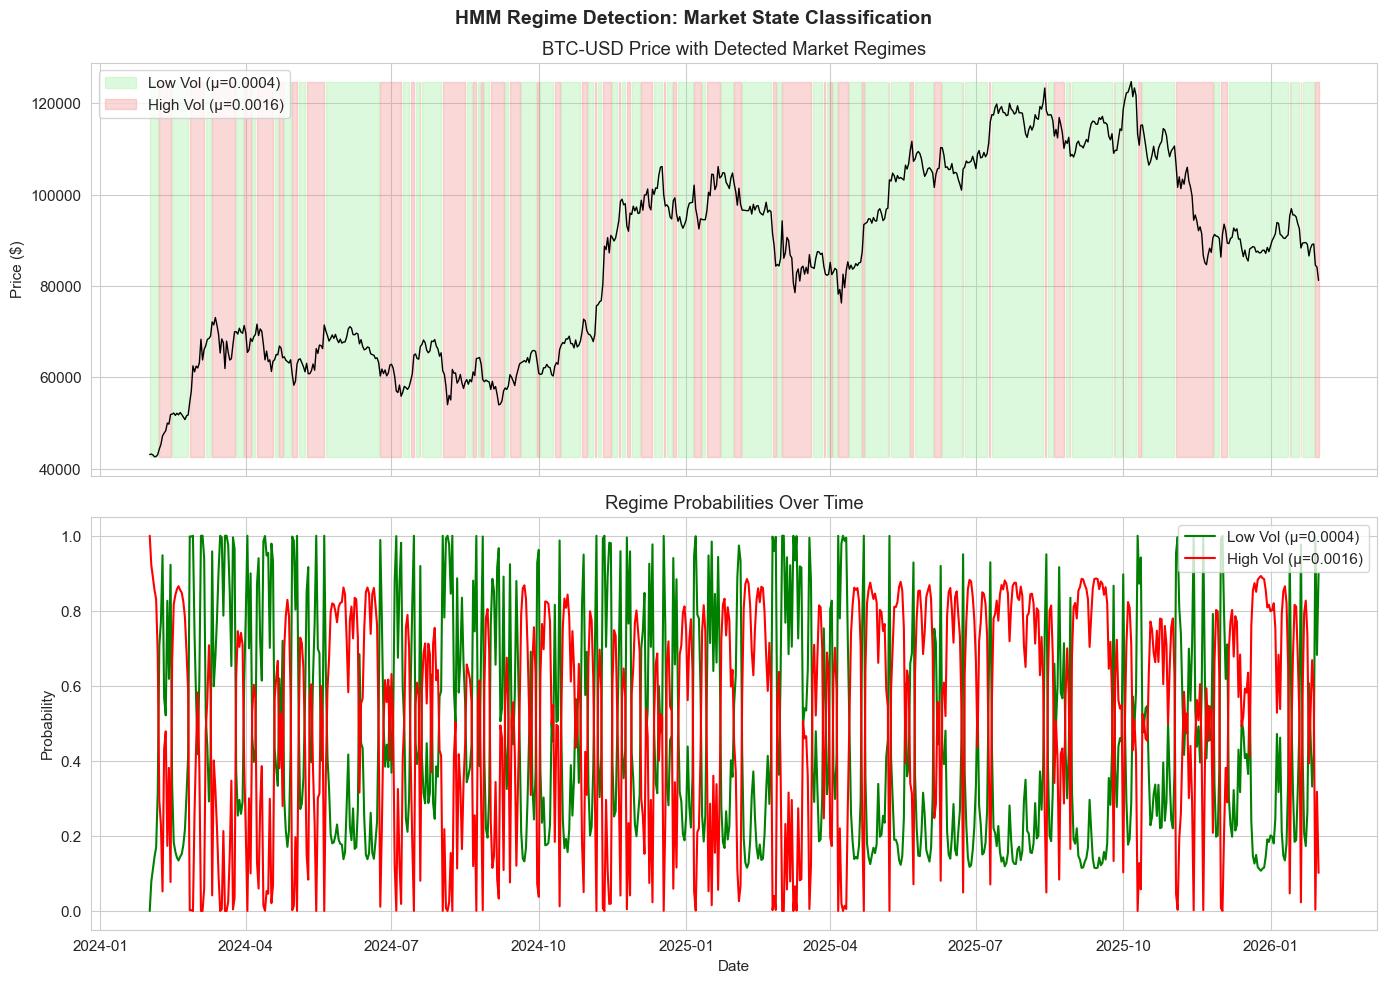

In [13]:
# ── Regime Detection: Price + Regime Overlay ──
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Map integer states to descriptive labels based on return statistics
n_states = regimes.nunique()
state_colors = ['lightgreen', 'lightcoral', 'lightyellow', 'lightgray'][:n_states]
state_labels = [f'State {i}' for i in range(n_states)]

regime_stats = detector.get_regime_statistics()
for state_idx in regime_stats.index:
    mean_ret = regime_stats.loc[state_idx, 'mean']
    std_ret = regime_stats.loc[state_idx, 'std']
    if mean_ret > 0 and std_ret < regime_stats['std'].median():
        state_labels[state_idx] = f'Low Vol (μ={mean_ret:.4f})'
    elif mean_ret > 0:
        state_labels[state_idx] = f'High Vol (μ={mean_ret:.4f})'
    else:
        state_labels[state_idx] = f'Bearish (μ={mean_ret:.4f})'

# Top panel: Price with regime background
btc_prices_aligned = btc_close.loc[regimes.index]
axes[0].plot(btc_prices_aligned, color='black', linewidth=1)
for state_idx in range(n_states):
    mask = regimes == state_idx
    axes[0].fill_between(regimes.index,
                        btc_prices_aligned.min(), btc_prices_aligned.max(),
                        where=mask, alpha=0.3, color=state_colors[state_idx],
                        label=state_labels[state_idx])
axes[0].set_title('BTC-USD Price with Detected Market Regimes')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')

# Bottom panel: Regime probabilities over time
for i in range(probs.shape[1]):
    axes[1].plot(probs.iloc[:, i], label=state_labels[i],
                color=['green', 'red', 'orange', 'gray'][i])
axes[1].set_title('Regime Probabilities Over Time')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.suptitle('HMM Regime Detection: Market State Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Scientific Interpretation — HMM Regime Detection**

The two-panel visualization shows the Hidden Markov Model applied to BTC daily returns.

**Top Panel — Price with Regime Overlay:** The colored background segments indicate which HMM state is active at each point. States are labelled by their return characteristics: "Low Vol" states (green) have smaller daily fluctuations, while "High Vol" states (red) capture periods of elevated volatility. Both states may show positive mean returns when the sample period is predominantly bullish — the HMM distinguishes regimes by *volatility*, not by return sign.

**Bottom Panel — Regime Probability Evolution:** The posterior probability curves show how confidently the HMM classifies each day. Probabilities near 100% indicate clear regime membership; values near 50% indicate regime boundaries or transitions. Rapid probability swings correspond to volatility regime changes visible in the price panel above.

**Interpreting the Results:**
- The regime statistics table (above) reports mean return, standard deviation, and observation count per state. The ratio of standard deviations characterises the volatility differential.
- The transition matrix shows regime persistence: diagonal values close to 1.0 indicate "sticky" regimes that tend to persist once entered (Hamilton, 1989).
- The BIC-based model selection chose 2 states for BTC, reflecting the dominant low-vol / high-vol dichotomy in this sample period.

**SPY Regime Detection (below):** SPY may produce a different number of states. With shorter samples or during calm markets, the HMM may detect rare extreme-volatility states with very few observations — these capture acute stress events and may have unusual statistics due to small sample sizes.

**Limitation:** Regime classification is sensitive to the sample window. A period dominated by bull markets will produce states that differ primarily in volatility, not in return sign. Longer samples spanning multiple bull/bear cycles would yield more balanced regime distributions.

### 3.5 Detect Regimes in SPY

In [14]:
spy_returns = np.log(spy_close / spy_close.shift(1)).dropna()

spy_detector = RegimeDetector(max_states=4)
with contextlib.redirect_stderr(io.StringIO()):
    spy_detector.fit(spy_returns, auto_select=True)
spy_regimes = spy_detector.predict_regimes()

print(f'SPY optimal states: {spy_regimes.nunique()}')
print(f'Current regime: {spy_regimes.iloc[-1]}')

spy_stats = spy_detector.get_regime_statistics()
print('\nSPY Regime Statistics:')
spy_stats

SPY optimal states: 2
Current regime: 0

SPY Regime Statistics:


,mean,std,min,max,count,proportion
regime,,,,,,
0,0.001143,0.006953,-0.020794,0.024562,458,0.914172
1,-0.003245,0.026569,-0.060327,0.099863,43,0.085828


---
## 4. Global Boosting Forecaster (LightGBM)

The `GlobalBoostForecaster` trains a single LightGBM model across multiple entities (countries, assets) with mixed-frequency feature support.

### 4.1 Prepare Multi-Entity Data

In [15]:
from timeseries_toolkit.models import GlobalBoostForecaster

# Create a simple multi-entity dataset from market data
# Entity 1: BTC returns with lagged features
# Entity 2: SPY returns with lagged features

def make_entity(series, name):
    """Create entity dict with lagged features."""
    returns = series.pct_change().dropna()
    features = {
        f'{name}_lag1': returns.shift(1),
        f'{name}_lag2': returns.shift(2),
        f'{name}_lag5': returns.shift(5),
        f'{name}_vol5': returns.rolling(5).std(),
    }
    # Drop NaN rows
    valid_idx = returns.index[5:]  # after lags settle
    y = returns.loc[valid_idx]
    X = {k: v.loc[valid_idx] for k, v in features.items()}
    return {'y': y, 'X': X}

all_data = {
    'BTC': make_entity(btc_close, 'btc'),
    'SPY': make_entity(spy_close, 'spy'),
}

print(f'BTC training samples: {len(all_data["BTC"]["y"])}')
print(f'SPY training samples: {len(all_data["SPY"]["y"])}')

BTC training samples: 726
SPY training samples: 496


### 4.2 Train and Predict

In [16]:
forecaster = GlobalBoostForecaster(random_state=42)
forecaster.fit(all_data)

# Predict the last known point for each entity
for entity_name, entity_data in all_data.items():
    # predict() needs the full series for feature engineering;
    # n_periods=1 returns only the last prediction.
    pred = forecaster.predict(
        entity_data['X'], y_series=entity_data['y'],
        entity_id=entity_name, n_periods=1
    )
    actual = entity_data['y'].iloc[-1]
    print(f'{entity_name}: predicted return = {pred[0]:.6f}, actual = {actual:.6f}')

print('\nGlobal model trained successfully across both entities.')

BTC: predicted return = -0.000137, actual = -0.034582
SPY: predicted return = 0.001561, actual = -0.002983

Global model trained successfully across both entities.


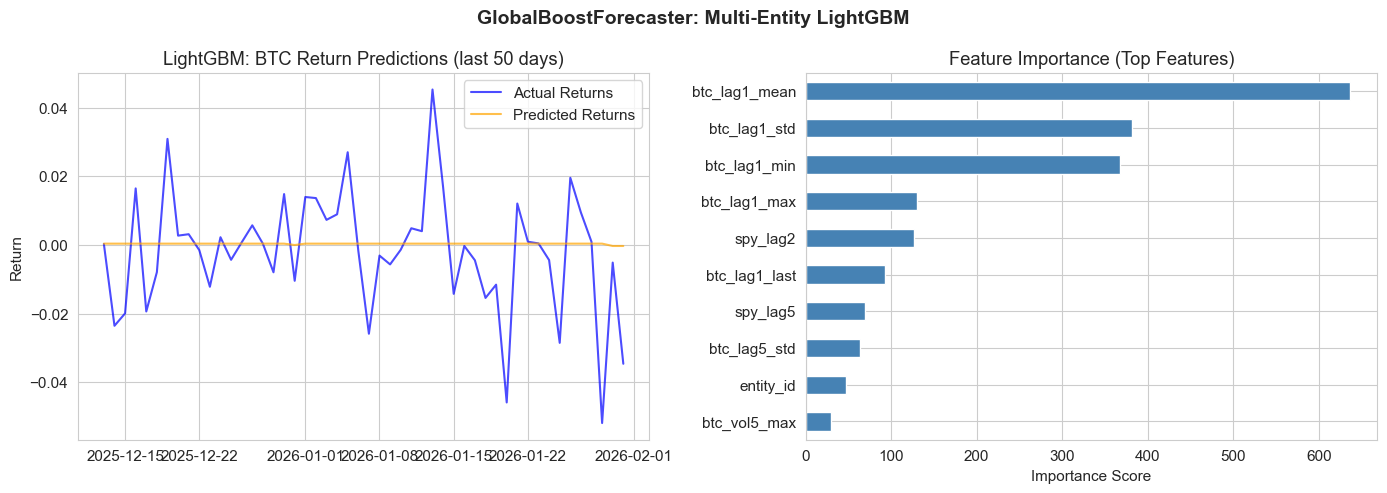

In [17]:
# ── LightGBM: Feature Importance ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Predictions vs actual for BTC (last 50 points)
btc_y = all_data['BTC']['y']
btc_preds = forecaster.predict(
    all_data['BTC']['X'], y_series=btc_y,
    entity_id='BTC', n_periods=len(btc_y)
)
n_show = min(50, len(btc_y))
axes[0].plot(btc_y.index[-n_show:], btc_y.values[-n_show:],
            label='Actual Returns', color='blue', alpha=0.7)
axes[0].plot(btc_y.index[-n_show:], btc_preds[-n_show:],
            label='Predicted Returns', color='orange', alpha=0.7)
axes[0].set_title('LightGBM: BTC Return Predictions (last 50 days)')
axes[0].set_ylabel('Return')
axes[0].legend()

# Right: Feature importance
importance = forecaster.get_feature_importance()
if importance is not None and len(importance) > 0:
    top_n = min(10, len(importance))
    top_imp = importance.head(top_n).sort_values()
    top_imp.plot(kind='barh', ax=axes[1], color='steelblue')
    axes[1].set_title('Feature Importance (Top Features)')
    axes[1].set_xlabel('Importance Score')
else:
    axes[1].text(0.5, 0.5, 'Feature importance not available',
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Feature Importance')

plt.suptitle('GlobalBoostForecaster: Multi-Entity LightGBM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Scientific Interpretation — LightGBM Global Forecaster**

The two-panel visualization shows the global LightGBM model trained on both BTC and SPY simultaneously.

**Left Panel — Predicted vs Actual Returns:** The line plot overlays model predictions (orange) on actual BTC daily returns (blue) for the last 50 days. A near-flat prediction line is common and *rational* for daily returns — the unconditional expected return is close to zero, and predicting near-zero minimises expected squared error when the signal-to-noise ratio is low. This is consistent with the Efficient Market Hypothesis.

**Right Panel — Feature Importance:** The horizontal bar chart reveals which lag features the model relies on most. If recent lags (lag_1, lag_2) dominate, the model exploits short-term momentum; if longer lags (lag_5) or volatility (vol_5) contribute, mean-reversion or volatility-clustering patterns may be present. The `entity_id` feature captures systematic differences between BTC and SPY return dynamics.

**Key Insights:**
- The global model approach (Montero-Manso & Hyndman, 2021) trains a single model across multiple entities, enabling transfer learning: patterns learned from SPY can inform BTC predictions and vice versa.
- The minimal feature set (4 lags + entity ID) is deliberately simple for this prototype. Production systems would include technical indicators, volume, volatility measures, sentiment, and cross-asset signals.
- Near-zero predictions for the most recent observation (shown above) reflect the model's rational response to uninformative features — with only lag-return features, daily asset returns are approximately unpredictable.

**Limitation:** With only lag features, the model has limited information to exploit. The value of this module lies in its architecture (global training, feature importance) rather than point accuracy on this minimal feature set.

---
## Summary

| Model | Class | Strengths |
|-------|-------|----------|
| Kalman Filter | `AutoKalmanFilter` | Handles non-stationarity natively, probabilistic framework, component decomposition |
| HMM Regime Detection | `RegimeDetector` | Identifies market states, provides transition probabilities |
| LightGBM Forecaster | `GlobalBoostForecaster` | Multi-entity training, feature-rich, fast |

The MarketIntelligence system (Notebook 04) automatically selects the best model based on data characteristics.